#Importing Needed Libraries#

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
from google.colab.patches import cv2_imshow

---

In [ ]:
path_to_image = '/content/Untitled.png'

---

---

#Load Image#

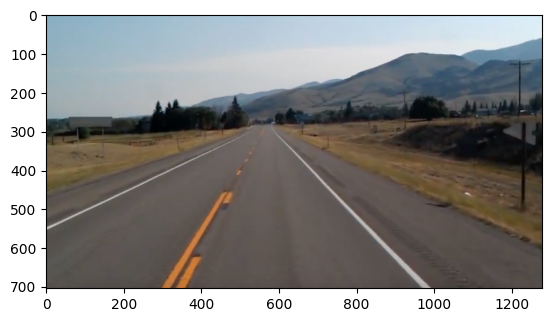

In [ ]:
img = cv2.imread(path_to_image, cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
image = img.copy()

In [ ]:
img.shape

(704, 1279, 3)

---

---

#Smoothing Image#

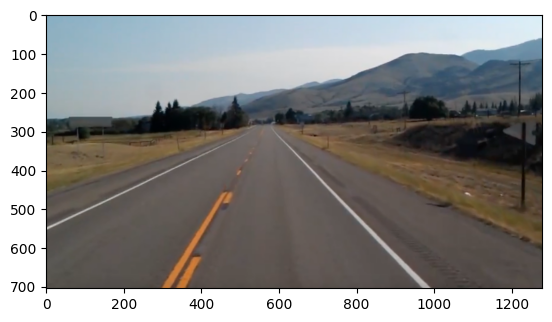

In [ ]:
img2 = cv2.medianBlur(img, 3)
plt.imshow(img2)

---

---

#Using Canny Algorithm For Edge Detection#

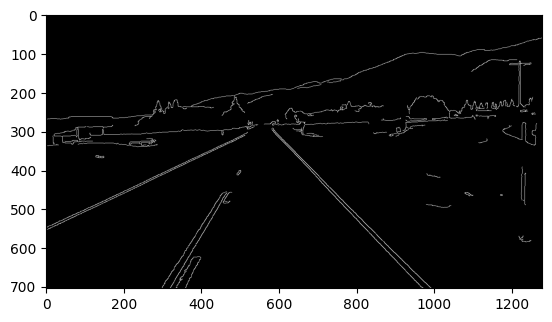

In [ ]:
edges = cv2.Canny(img2, 50, 150)
plt.imshow(edges, cmap='gray')

---

---

#Defining Region Of Interest#

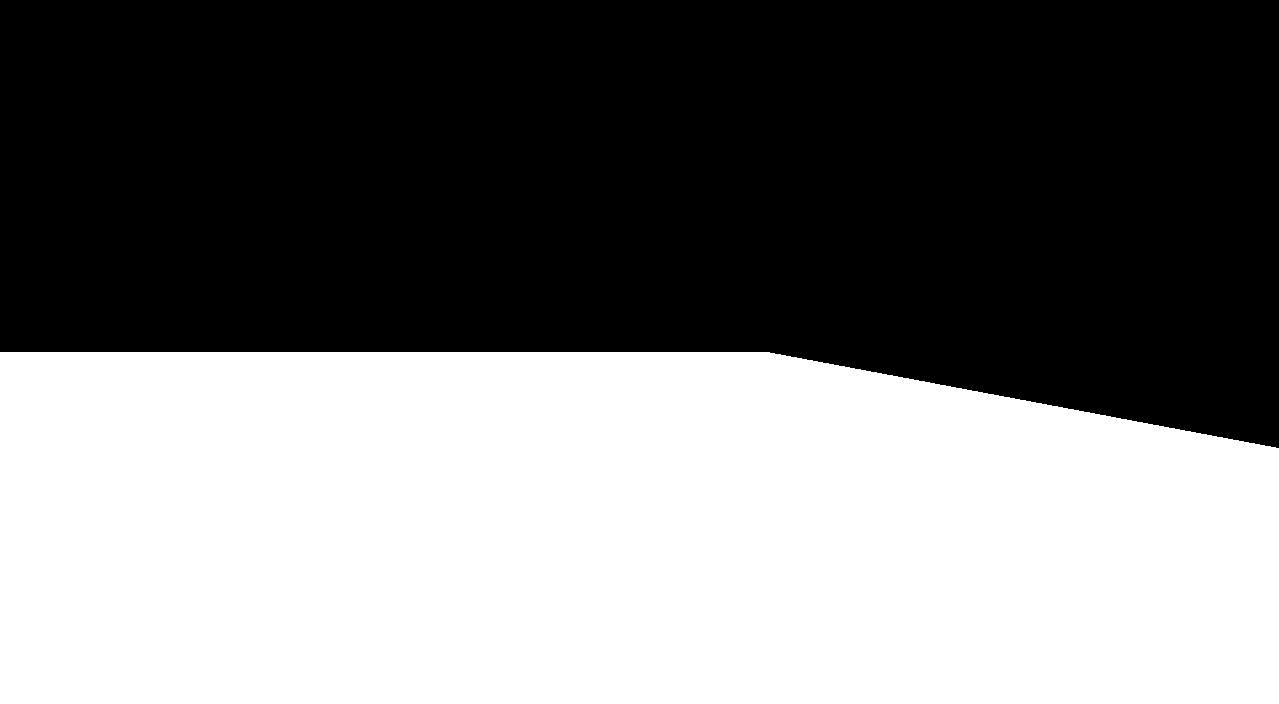

In [ ]:
height, width = img.shape[:2]
mask = np.zeros_like(edges)
#  el polyogn ma4y ezay ? bottom left  bottom right  top left top right
polygon = np.array([[
    (0, height), (width * 0.9 + 1500, height),
    (width * 0.6, height * 0.5), (0, height * 0.5)
]], np.int32)
cv2.fillPoly(mask, polygon, 255)
cv2_imshow(mask)

edges_masked = cv2.bitwise_and(edges, mask)

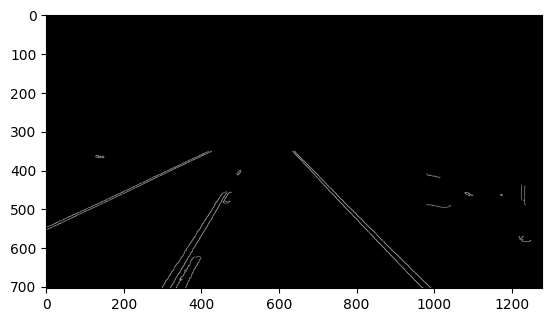

In [ ]:
plt.imshow(edges_masked, cmap='gray')

---

---

#Hough Transform#

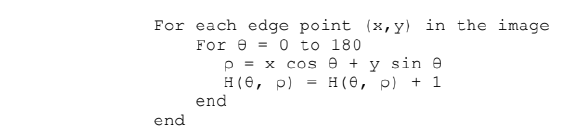

In [ ]:
edges_masked.shape

(704, 1279)

In [ ]:
theta_range = np.deg2rad(np.arange(0, 180, 1))  # Convert to radians
p_max = int(np.sqrt(edges_masked.shape[0]**2 + edges_masked.shape[1]**2)) # pythogres thorem
accumulator = np.zeros((2 * p_max, len(theta_range)), dtype=np.int32) # el P mmkn ttl3 negative f el acc kda mn -p l p w kol row --> theta cells

In [ ]:
p_max

1459

In [ ]:
y_indices, x_indices = np.nonzero(edges_masked)
for x, y in zip(x_indices, y_indices):
    for theta_idx, theta in enumerate(theta_range):
        rho = int(x * np.cos(theta) + y * np.sin(theta)) + p_max # rho mmkn ttl3 negative hna
        accumulator[rho, theta_idx] += 1

#Plotting ACC Array#

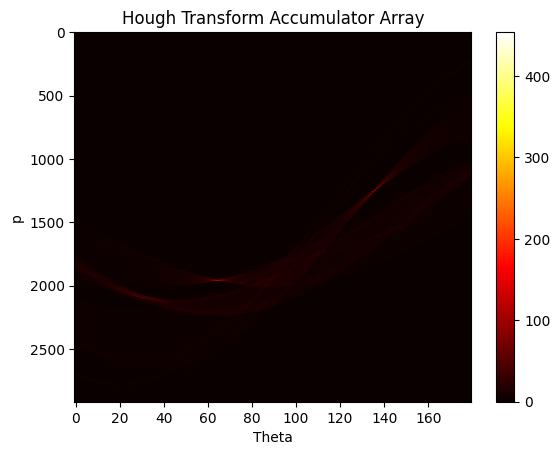

In [ ]:
plt.imshow(accumulator, cmap='hot', aspect='auto')
plt.title('Hough Transform Accumulator Array')
plt.xlabel('Theta')
plt.ylabel('p')
plt.colorbar()
plt.show()

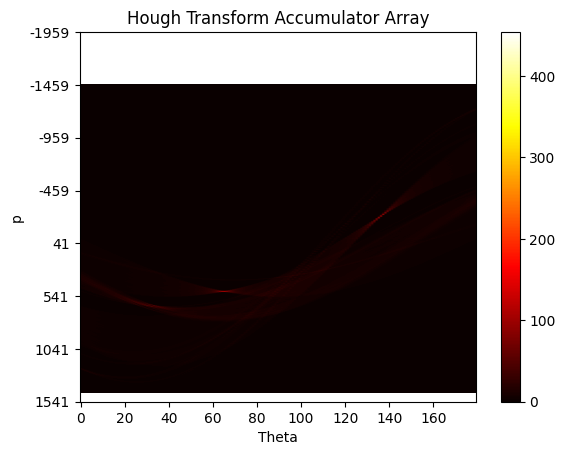

In [ ]:

plt.imshow(accumulator, cmap='hot', aspect='auto')
plt.title('Hough Transform Accumulator Array')
plt.xlabel('Theta')
plt.ylabel('p')
yticks, ylabels = plt.yticks()
plt.yticks(yticks, [int(y - p_max) for y in yticks])

plt.colorbar()
plt.show()

---

---

#Find Peaks in ACC Array#

In [ ]:
filtered_accumulator = maximum_filter(accumulator, size=5)
peaks = (accumulator == filtered_accumulator) & (accumulator > 173)
p_theta_pairs = np.column_stack(np.nonzero(peaks))

---

---


#Drawing Detetced Lines#

X1 --> 1528    Y1 --> 1309  X2 --> -1199  Y2 --> -1616
X1 --> 1557    Y1 --> 1271  X2 --> -1271  Y2 --> -1557
X1 --> 2022    Y1 --> -395  X2 --> -1602  Y2 --> 1294
X1 --> 1575    Y1 --> -1386  X2 --> -484  Y2 --> 2041


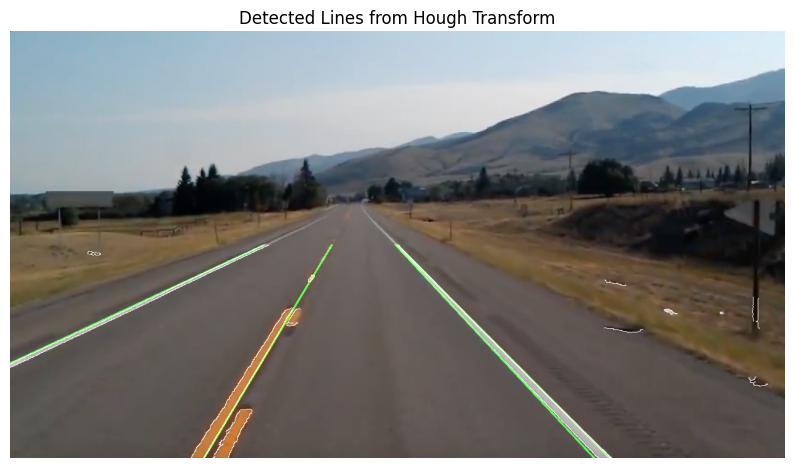

In [ ]:
output_image = cv2.cvtColor(edges_masked, cv2.COLOR_GRAY2BGR)
previous_x1 = None
# ---------------------------------------------------------------------  #

for line in p_theta_pairs:
    p_idx, theta_idx = line
    theta = theta_range[theta_idx]
    p = p_idx - p_max
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * p
    y0 = b * p
    x1 = int(x0 + 2000 * b)
    y1 = int(y0 - 2000 * a)
    x2 = int(x0 - 2000 * b)
    y2 = int(y0 + 2000 * a)

    if previous_x1 is not None and abs(x1 - previous_x1) < 20:
        continue
    previous_x1 = x1

    cv2.line(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    print(f"X1 --> {x1}    Y1 --> {y1}  X2 --> {x2}  Y2 --> {y2}")
    output_image = cv2.bitwise_and(output_image, output_image, mask=mask)
    image[np.where(output_image != 0)] = output_image[np.where(output_image != 0)]

# ---------------------------------------------------------------------  #
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.title('Detected Lines from Hough Transform')
plt.axis('off')
plt.show()


---

---

#Seeing Each Line Alone TO try to pick some of them#

In [ ]:
# output_image = cv2.cvtColor(edges_masked, cv2.COLOR_GRAY2BGR)
# print(f"How many lines have been detected? {len(p_theta_pairs)}")
# previous_x1 = None

# for i, line in enumerate(p_theta_pairs):
#     line_image = output_image.copy()
#     p_idx, theta_idx = line
#     theta = theta_range[theta_idx]
#     p = p_idx - p_max
#     a = np.cos(theta)
#     b = np.sin(theta)
#     x0 = a * p
#     y0 = b * p
#     x2 = int(x0 + 1000 * (-b))
#     y2 = int(y0 + 1000 * (a))
#     x1 = int(x0 - 1000 * (-b))
#     y1 = int(y0 - 1000 * (a))

#     if previous_x1 is not None and abs(x1 - previous_x1) < 10:
#         continue
#     previous_x1 = x1

#     cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 3)
#     print(f"Line {i+1}: X1 --> {x1}    Y1 --> {y1}  X2 --> {x2}  Y2 --> {y2}")
#     line_image = cv2.bitwise_and(line_image, line_image, mask=mask)
#     single_line_output = image.copy()
#     single_line_output[np.where(line_image != 0)] = line_image[np.where(line_image != 0)]
#     plt.figure(figsize=(10, 8))
#     plt.imshow(single_line_output)
#     plt.title(f'Detected Line {i+1}')
#     plt.axis('off')
#     plt.show()


---

---